Installare le librerie necessarie

In [ ]:
pip install pycrostates

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.9/169.9 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 94.1 MB/s eta 0:00:00


In [ ]:
pip install mne

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import mne
import os
import pycrostates
from pycrostates.preprocessing import extract_gfp_peaks, resample
from pycrostates.cluster import ModKMeans
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [ ]:
## montare google drive su colab

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
base_path = "/content/drive/MyDrive/derivatives/" # path alla cartella dove sono contenuti i dati EEG raw

In [ ]:
# ============================================
# 0. Caricamento dati EEG raw
# ============================================
# iteriamo sui dati grezzi (raw EEG) dei soggetti

total_data_raw = []

for i in range(1,65): #A,C

    subject = f"sub-{i:03d}"
    subject_file = os.path.join(base_path, subject, "eeg", f"{subject}_task-eyesclosed_eeg.set")
    if os.path.exists(subject_file):
        raw = mne.io.read_raw_eeglab(subject_file, preload=True)
        total_data_raw.append(raw)
    else:
        print(f"File non trovato: {subject_file}")

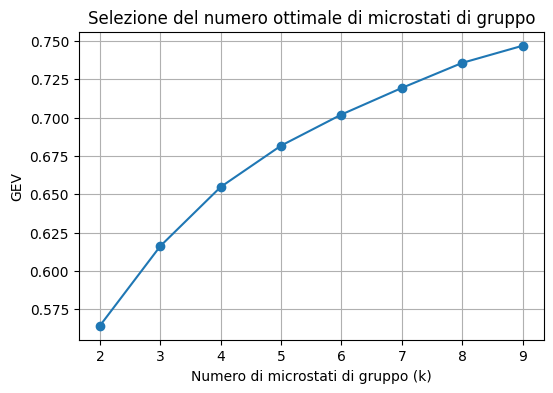

In [ ]:

# ============================================
# 1. Estrazione dei microstati EEG a livello individuale
# ============================================

individual_cluster_centers = list()  # lista per salvare i centri dei cluster di ogni soggetto
from pycrostates.io import ChData

for raw in total_data_raw:
    raw.crop(0, 30)  # Limitiamo i dati ai primi 30 secondi per velocizzare il calcolo
    raw.set_eeg_reference("average")  # Impostiamo la referenza EEG come media dei canali

    # Estrazione dei picchi di GFP (Global Field Power)
    # GFP è una misura della variabilità spaziale del segnale EEG
    gfp_peaks = extract_gfp_peaks(raw)

    # Clustering a livello soggetto con algoritmo ModKMeans
    # n_clusters=5 significa che cerchiamo 5 microstati per ogni soggetto
    ModK = ModKMeans(n_clusters=5, random_state=42)
    ModK.fit(gfp_peaks, n_jobs=2)  # n_jobs=2 usa 2 core per velocizzare
    individual_cluster_centers.append(ModK.cluster_centers_)  # Salviamo i centri dei cluster

# ============================================
# 2. Creazione dei cluster di gruppo
# ============================================

# Combiniamo i centri dei cluster di tutti i soggetti in una matrice
group_cluster_centers = np.vstack(individual_cluster_centers).T
group_cluster_centers = ChData(group_cluster_centers, ModK.info)

# Normalizzazione delle mappe:
# - Rimuoviamo la media (mean centering)
# - Normalizziamo la norma (lunghezza del vettore)
group_cluster_centers._data -= group_cluster_centers._data.mean(axis=0, keepdims=True)
norms = np.linalg.norm(group_cluster_centers._data, axis=0, keepdims=True)
group_cluster_centers._data /= norms

# ============================================
# 3. Selezione del numero ottimale di microstati di gruppo
# ============================================

ks = range(2, 10)  # Testiamo da 2 a 9 cluster
gev_scores = []    # Lista per salvare il GEV (Global Explained Variance)

for k in ks:
    ModK_tmp = ModKMeans(n_clusters=k, random_state=42)
    ModK_tmp.fit(group_cluster_centers, n_jobs=2)
    gev_scores.append(ModK_tmp.GEV_)  # Salviamo il GEV per ogni k

# Visualizziamo il GEV per scegliere il numero ottimale di microstati
plt.figure(figsize=(6,4))
plt.plot(ks, gev_scores, marker='o')
plt.xlabel('Numero di microstati di gruppo (k)')
plt.ylabel('GEV')
plt.title('Selezione del numero ottimale di microstati di gruppo')
plt.grid(True)
plt.show()


In [ ]:
# Dal grafico (elbow method) scegliamo k=4
ModK_tmp = ModKMeans(n_clusters=4, random_state=42)
ModK_tmp.fit(group_cluster_centers, n_jobs=2)


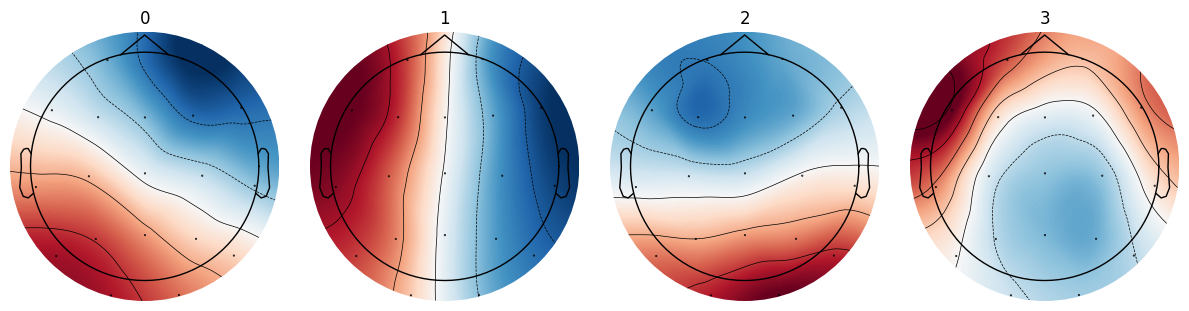

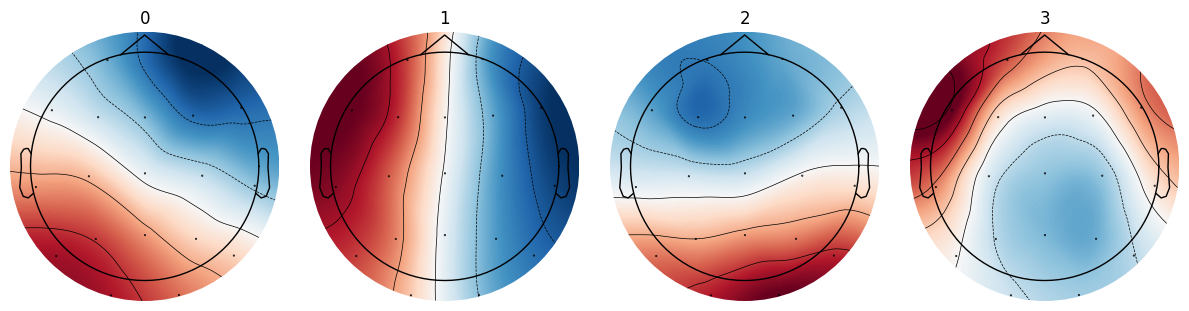

In [ ]:
ModK_tmp.plot()

In [ ]:

# ============================================
# 4. Segmentazione dei dati EEG in microstati
# ============================================


microstate_data = list()
for raw in total_data_raw:
    raw.crop(0, 30)  # crop the dataset to speed up computation
    # predict => Segment Raw or Epochs into microstate sequence.
    # Segment instance into microstate sequence using the **segmentation smoothing algorithm**.
    segmentation = ModK_tmp.predict(raw, factor=10, half_window_size=8)
    d = segmentation.compute_parameters() # calcoliamo i parametri dei microstati
    microstate_data.append(d)

In [ ]:
dataset_path = "/content/drive/MyDrive/participants.xlsx"
dataset = pd.read_excel(dataset_path)
labels = dataset["Group"].iloc[:66] #A,C

In [ ]:

# ============================================
# 5. Creazione del dataset per la classificazione
# ============================================

df = pd.DataFrame(microstate_data)
df["group"] = labels

,0_mean_corr,0_gev,0_occurrences,0_timecov,0_meandurs,1_mean_corr,1_gev,1_occurrences,1_timecov,1_meandurs,...,2_gev,2_occurrences,2_timecov,2_meandurs,3_mean_corr,3_gev,3_occurrences,3_timecov,3_meandurs,group
0,0.595338,0.166125,5.221932,0.299926,0.057436,0.473669,0.021151,2.108857,0.084622,0.040127,...,0.190537,5.154984,0.322756,0.062610,0.514757,0.093286,5.288880,0.292696,0.055342,A
1,0.641415,0.146973,5.012699,0.246491,0.049173,0.592161,0.081987,4.478011,0.242748,0.054209,...,0.254642,5.781313,0.308849,0.053422,0.582902,0.079596,4.812191,0.201912,0.041958,A
2,0.661160,0.135029,5.450411,0.235204,0.043153,0.578312,0.071924,4.213201,0.199291,0.047302,...,0.276914,6.420116,0.360797,0.056198,0.580428,0.080282,4.647897,0.204708,0.044043,A
3,0.590477,0.087557,3.645485,0.183144,0.050239,0.629937,0.198498,5.050167,0.382542,0.075748,...,0.093697,3.377926,0.190234,0.056317,0.598958,0.102027,3.678930,0.244080,0.066345,A
4,0.423954,0.015784,3.243496,0.153147,0.047216,0.365339,0.008737,2.708487,0.119842,0.044247,...,0.033877,5.116030,0.254330,0.049712,0.524801,0.161126,5.216345,0.472681,0.090615,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,0.531938,0.212419,6.568200,0.434931,0.066218,0.390701,0.011150,2.382249,0.089504,0.037571,...,0.061207,4.832562,0.223659,0.046282,0.477139,0.054658,5.070787,0.251906,0.049678,C
60,0.655863,0.436512,4.219975,0.492866,0.116794,0.488316,0.003413,1.406658,0.059816,0.042524,...,0.007831,3.081251,0.146694,0.047609,0.551263,0.044118,4.119499,0.300623,0.072976,C
61,0.591308,0.113640,5.247677,0.261582,0.049847,0.541243,0.073590,3.476168,0.159302,0.045827,...,0.286217,6.618089,0.488468,0.073808,0.484962,0.025044,2.473427,0.090648,0.036649,C
62,0.636297,0.116026,4.985946,0.224468,0.045020,0.520639,0.034258,3.112033,0.120399,0.038688,...,0.316958,6.458305,0.426984,0.066114,0.587671,0.085008,4.450542,0.228149,0.051263,C


In [ ]:
# Rimuoviamo alcuni parametri che potrebbero avere correlazioni con gli altri parametri del dataset

df_reduced = df.drop(columns=["0_meandurs", "0_mean_corr",
                              "1_meandurs", "1_mean_corr",
                              "2_meandurs", "2_mean_corr",
                              "3_meandurs", "3_mean_corr"])

X = df_reduced.drop(columns = ["group", "unlabeled"])
y = df_reduced["group"]
le = LabelEncoder()
y= le.fit_transform(y)

In [ ]:
# ============================================
# 6. Split in train e test
# ============================================

RANDOM_SEED = 42
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=RANDOM_SEED, stratify = y)

In [ ]:

# ============================================
# 7. Pipeline di Machine Learning
# ============================================

# Pipeline allows you to sequentially apply a list of transformers to preprocess the data
# and, if desired, conclude the sequence with a final predictor for predictive modeling.

pipe = Pipeline([
    ('scaler', StandardScaler()), # Standardizzazione delle feature
    ('clf', LogisticRegression(
        class_weight='balanced', # Compensa il lieve sbilanciamento delle classi
        solver='saga', # necessario per L1/elasticnet
        max_iter=5000
    ))
])


cv_params = [
    # L2 penalization
    {
        'clf__penalty': ['l2'],
        'clf__C': [0.01, 0.1, 0.5, 1, 5, 10]
    },

    # L1 penalization
    {
        'clf__penalty': ['l1'],
        'clf__C': [0.01, 0.1, 0.5, 1, 5, 10]
    },

    # ElasticNet
    {
        'clf__penalty': ['elasticnet'],
        'clf__C': [0.01, 0.1, 0.5, 1, 5, 10],
        'clf__l1_ratio': [0.1, 0.3, 0.5, 0.7, 1.0]
    }
]


scoring = {
    'roc_auc' : 'roc_auc',
    'f1_weighted': 'f1_weighted'
}

cv = StratifiedKFold(n_splits=8, shuffle=True, random_state=42)


# La grid search è una tecnica utilizzata nel machine learning per trovare i migliori iperparametri di un modello
# e consiste nel definire una griglia di valori per ogni iperparametro e testare tutte le possibili combinazioni di valori.
grid = GridSearchCV(
    pipe,
    cv_params,
    scoring=scoring,
    refit='f1_weighted', # Modello finale scelto in base a F1 pesato
    cv=cv,
    n_jobs=-1,
    verbose=2
)


# ============================================
# 8. Addestramento del modello
# ============================================

grid.fit(X_train, y_train)


Fitting 8 folds for each of 42 candidates, totalling 336 fits


GridSearchCV(cv=StratifiedKFold(n_splits=8, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('clf',
                                        LogisticRegression(class_weight='balanced',
                                                           max_iter=5000,
                                                           solver='saga'))]),
             n_jobs=-1,
             param_grid=[{'clf__C': [0.01, 0.1, 0.5, 1, 5, 10],
                          'clf__penalty': ['l2']},
                         {'clf__C': [0.01, 0.1, 0.5, 1, 5, 10],
                          'clf__penalty': ['l1']},
                         {'clf__C': [0.01, 0.1, 0.5, 1, 5, 10],
                          'clf__l1_ratio': [0.1, 0.3, 0.5, 0.7, 1.0],
                          'clf__penalty': ['elasticnet']}],
             refit='f1_weighted',
             scoring={'f1_weighted': 'f1_weighted', 'roc_auc': 'roc_auc'},
             verbose=2)

In [ ]:
# ============================================
# 9. Valutazione del modello sul set di test
# ============================================
print("Best parameters found:")
print(grid.best_params_)
print("\nBest f1_macro score:", grid.best_score_)


# usa il best estimator trovato prima

model = grid.best_estimator_

y_pred = model.predict(X_test)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Best parameters found:
{'clf__C': 0.5, 'clf__l1_ratio': 0.3, 'clf__penalty': 'elasticnet'}

Best f1_macro score: 0.7412202380952381

Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.89      0.80         9
           1       0.80      0.57      0.67         7

    accuracy                           0.75        16
   macro avg       0.76      0.73      0.73        16
weighted avg       0.76      0.75      0.74        16



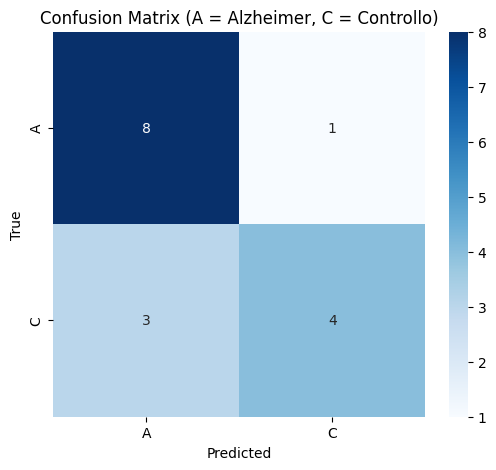

In [ ]:
# ============================================
# 9. Confusion matrix
# ============================================
cm = confusion_matrix(y_test, y_pred)

# Etichette delle classi
labels = ['A', 'C']

# Creazione della heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)

plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (A = Alzheimer, C = Controllo)')
plt.show()
